# Brazilian Securities

---

### Wilson Freitas


# Brazilian Securities

---

### Wilson Freitas

# Lecture 2

- Flat-forward interpolation with COPOM Meetings
- Treasury Direct contracts
	- Floating: LFT
	- Fixed: LTN, NTN-F
	- Indexed: NTN-B, Bullet NTN-B
- ANBIMA Data
- Bootstrap
- Nelson-Siegel coeficients ANBIMA
- Implied Inflation

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bcb import currency, sgs
import bizdays

from myfuncs import get_contracts

## DI x PRE Curve

In [2]:
refdate = datetime.datetime(2021, 11, 1)
df = get_contracts(refdate)

In [3]:
di1 = df[(df['Mercadoria'] == 'DI1') & (df['PUAtual'] != 100000.0)].copy()

In [4]:
MARKET_CALENDAR = bizdays.Calendar.load('ANBIMA.cal')
di1['Maturity'] = di1['Vencimento'].map(MARKET_CALENDAR.following)
di1['DU'] = di1.apply(lambda x: MARKET_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
di1['Rate'] = (100000 / di1['PUAtual'])**(252 / di1['DU']) - 1
di1_curve = di1[['DataRef', 'Maturity', 'DU', 'Rate']]

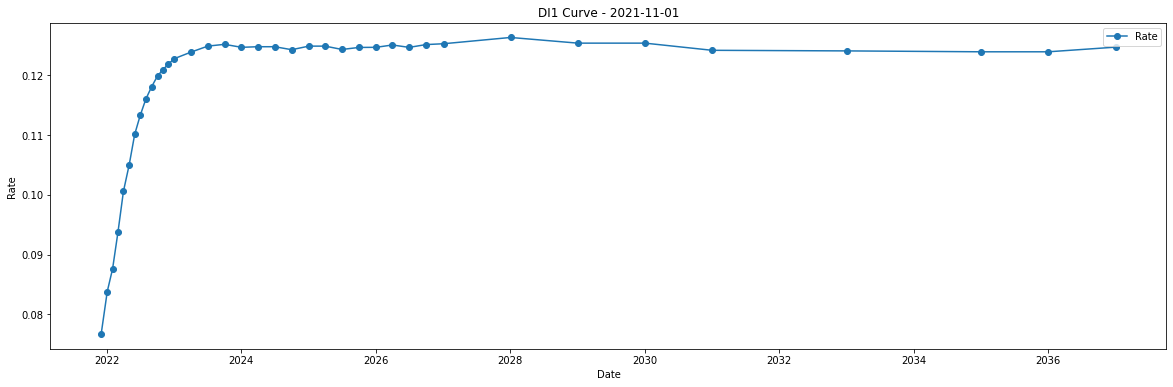

In [5]:
di1_curve.plot(x='Maturity', y='Rate', figsize=(20,6), style='-o',
               ylabel='Rate', xlabel='Date', title='DI1 Curve - 2021-11-01');

### Exponential Flat-Forward Interpolation

In [6]:
di1_curve_h = di1_curve.reset_index(drop=True).head()

In [9]:
cdi = sgs.get(('CDI', 4389), start_date='2021-11-01', end_date='2021-11-01')

In [10]:
first_term = pd.DataFrame({
    'DataRef': datetime.datetime(2021,11,1),
    'Maturity': ['2021-11-03'],
    'DU': [1],
    'Rate': [cdi.iloc[0, 0]/100]
})

In [11]:
di1_curve_h = pd.concat([first_term, di1_curve_h], axis=0).reset_index(drop=True)
di1_curve_h

,DataRef,Maturity,DU,Rate
0,2021-11-01,2021-11-03,1,0.07650
1,2021-11-01,2021-12-01,20,0.07670
2,2021-11-01,2022-01-03,43,0.08380
3,2021-11-01,2022-02-01,64,0.08762
4,2021-11-01,2022-03-02,83,0.09371
5,2021-11-01,2022-04-01,105,0.10060


In [12]:
log_pu = np.log((1 + di1_curve_h['Rate'])**(di1_curve_h['DU']/252))
terms = di1_curve_h['DU']
i_terms = np.array(range(terms.min(), terms.max()))
pu = np.exp(np.interp(i_terms, terms, log_pu))
i_curve = pd.DataFrame({
    'DU': i_terms,
    'Maturity': MARKET_CALENDAR.vec.offset('2021-11-01', i_terms),
    'Rate': pu ** (252 / i_terms) - 1
})

In [15]:
i_curve['Factor'] = (1 + i_curve['Rate'])**(i_curve['DU']/252)
i_curve['Factor_p'] = i_curve['Factor'].shift(1)
i_curve['FwdRate'] = (i_curve['Factor']/i_curve['Factor_p'])**252 - 1

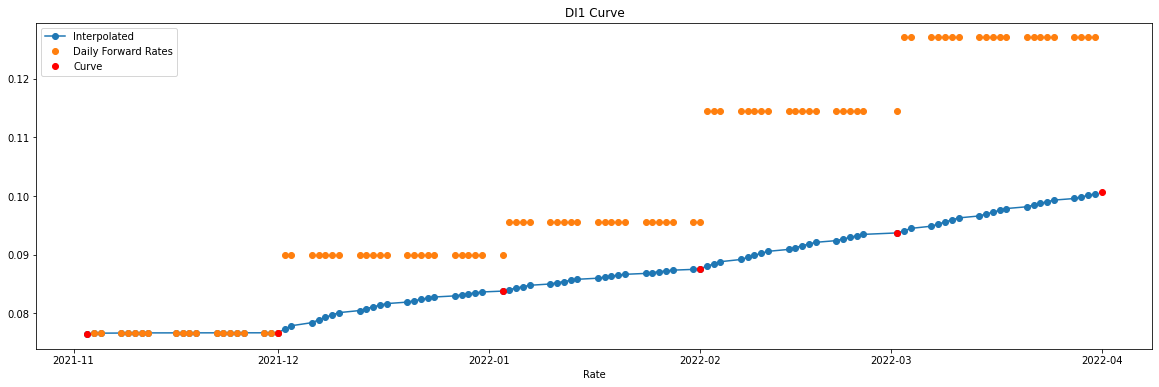

In [16]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['Rate'], '-o')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['Interpolated', 'Daily Forward Rates', 'Curve'])
plt.show()

## COPOM Meetings

In [19]:
rates = sgs.get(dict(SELICTARGET=432, CDI=4389), start_date='2021-09-01', end_date='2021-12-31')

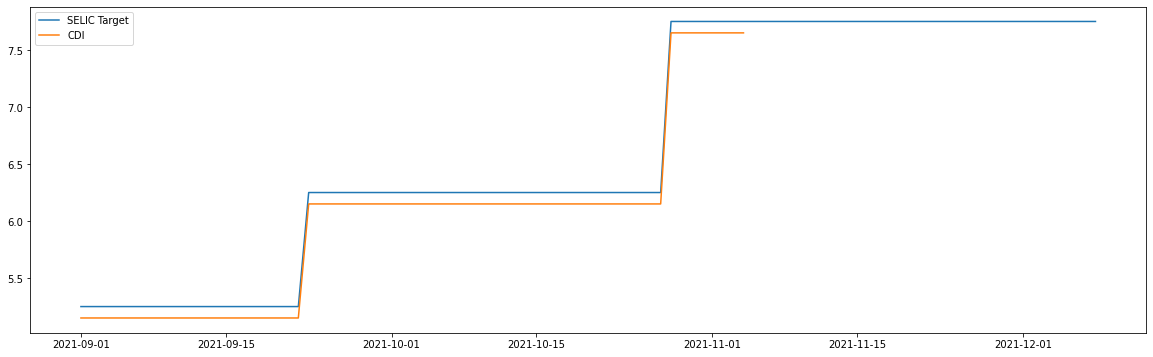

In [32]:
plt.figure(figsize=(20,6))
plt.plot(rates[0].index, rates[0]);
plt.plot(rates[1].index, rates[1]);
plt.legend(['SELIC Target', 'CDI']);

In the same chart:

- Historical SELIC Target
- Daily Forward Rates

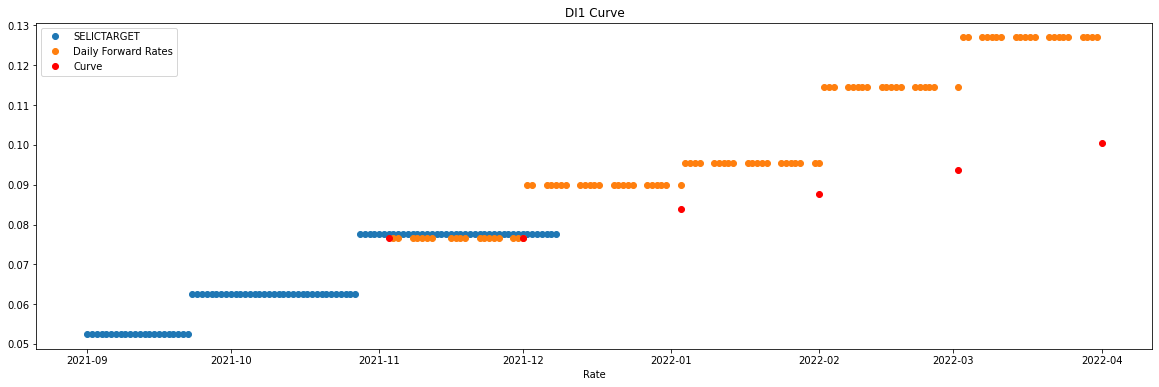

In [37]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(rates[0].index, rates[0]/100, 'o')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['SELICTARGET', 'Daily Forward Rates', 'Curve'])
plt.show()

### COPOM Meetings considerations

* Is is a good idea to consider the COPOM Meetings in the interpolation.
* Specially the **first meeting** that is more clear and presents a direct result.

## Tesouro Direto -- Government Bonds

* Government Bonds are daily traded in the Tesouro Direto

* Contracts traded in Tesouro Direto
    * LFT: Floating Rate Note
    * LTN: Fixed Rate Note
    * NTN-F: Fixed Rate Note with Coupons
    * NTN-B: Inflation Indexed with Coupons
    * NTN-B Principal: Inflation Indexed Bullet Bond


### LFT

$$
LFT = \frac{VNA}{(1 + s)^{DU/252}}
$$

$$
VNA = 1000 \prod_{n=1}^T(1 + SELIC_{n})^{1/252}
$$


### LTN

![](images/fluxo-de-caixa-ltn.png)

$$
VP_t = \frac{1000}{(1 + y_t)^T}
$$



### NTN-F

![](images/fluxo-de-caixa-ntnf.png)

$$
VP_t = \sum_{k=1}^{N}\frac{1000\cdot[(1.10)^{0.5}-1]}{(1+y_t)^{t_k}} + \frac{1000}{(1 + y_t)^{t_N}}
$$

### NTN-B Principal

![](images/fluxo-de-caixa-ntnb-principal.png)

$$
VP_t = \frac{VNA_t}{(1 + c_t)^T}
$$

![](images/vna.png)

<https://www.anbima.com.br/pt_br/informar/valor-nominal-atualizado.htm>

### NTN-B

![](images/fluxo-de-caixa-ntnb.png)

$$
VP_t = \sum_{k=1}^{N}\frac{VNA_t\cdot[(1.06)^{0.5}-1]}{(1+y_t)^{t_k}} + \frac{VNA_t}{(1 + y_t)^{t_N}}
$$

### Data

* <https://www.anbima.com.br/pt_br/informar/valor-nominal-atualizado.htm>

* <https://www.anbima.com.br/pt_br/informar/taxas-de-titulos-publicos.htm>

* <https://www.tesourodireto.com.br/titulos/precos-e-taxas.htm>

* <https://www.anbima.com.br/pt_br/informar/curvas-de-juros-fechamento.htm>

In [48]:
df = pd.read_parquet('data/2021-11-01.parquet')

In [49]:
df

,symbol,refdate,cod_selic,issue_date,maturity_date,bid_yield,ask_yield,ref_yield,price
0,LTN,2021-11-01,100000,2018-01-05,2022-01-01,8.3786,8.3490,8.3700,986.377808
1,LTN,2021-11-01,100000,2020-01-03,2022-04-01,10.0547,10.0280,10.0447,960.902954
2,LTN,2021-11-01,100000,2018-06-21,2022-07-01,11.3245,11.3034,11.3150,931.427257
3,LTN,2021-11-01,100000,2020-07-03,2022-10-01,11.9885,11.9672,11.9797,901.074386
4,LTN,2021-11-01,100000,2016-01-20,2023-01-01,12.3164,12.3025,12.3092,873.337504
5,LTN,2021-11-01,100000,2019-04-05,2023-07-01,12.5288,12.5172,12.5230,822.251181
6,LTN,2021-11-01,100000,2020-01-03,2024-01-01,12.5514,12.5400,12.5450,775.183013
7,LTN,2021-11-01,100000,2021-01-08,2024-07-01,12.5575,12.5419,12.5511,731.284206
8,LTN,2021-11-01,100000,2018-02-01,2025-01-01,12.5426,12.5223,12.5317,688.387569
9,NTN-C,2021-11-01,770100,2000-07-01,2031-01-01,5.6433,3.6057,4.4585,9395.480705


In [183]:
ltn = df[df['symbol'] == 'LTN'].copy()

In [184]:
ltn['fixing'] = ltn['maturity_date'].map(MARKET_CALENDAR.following)
ltn['DU'] = list(MARKET_CALENDAR.vec.bizdays(ltn['refdate'], ltn['fixing']))

In [185]:
ltn_terms = ltn[['refdate', 'maturity_date', 'DU', 'ref_yield']]

In [186]:
selic = sgs.get({'SELIC': 1178}, start_date='2021-11-01', end_date='2021-11-01')
first_term = pd.DataFrame({
    'refdate': ['2021-11-01'],
    'maturity_date': ['2021-11-03'],
    'DU': [1],
    'ref_yield': [selic.iloc[0, 0]]
})

In [187]:
ltn_curve = pd.concat([first_term, ltn_terms], axis=0).reset_index(drop=True)

In [188]:
ltn_curve

,refdate,maturity_date,DU,ref_yield
0,2021-11-01,2021-11-03,1,7.6500
1,2021-11-01,2022-01-01,43,8.3700
2,2021-11-01,2022-04-01,105,10.0447
3,2021-11-01,2022-07-01,167,11.3150
4,2021-11-01,2022-10-01,232,11.9797
5,2021-11-01,2023-01-01,294,12.3092
6,2021-11-01,2023-07-01,418,12.5230
7,2021-11-01,2024-01-01,543,12.5450
8,2021-11-01,2024-07-01,667,12.5511
9,2021-11-01,2025-01-01,797,12.5317


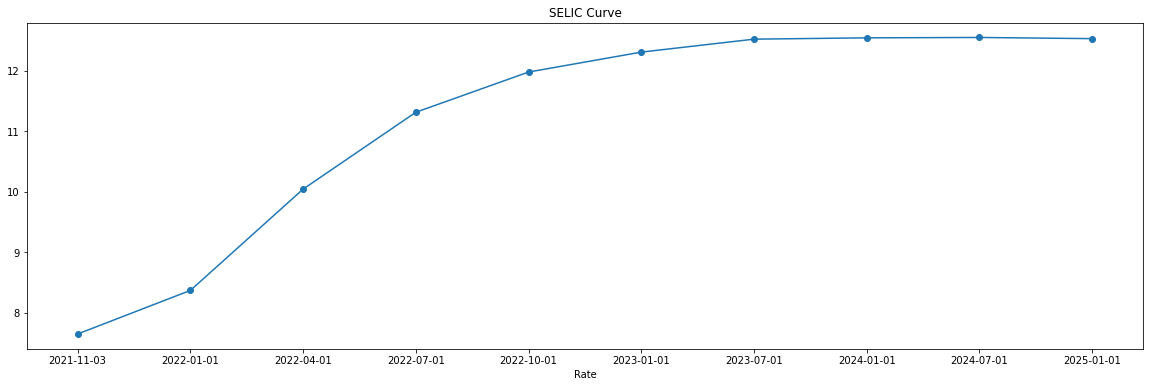

In [94]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('SELIC Curve')
plt.plot(ltn_curve['maturity_date'], ltn_curve['ref_yield'], '-o')
plt.show()

In [217]:
def discount_curve_builder(terms, rates, dib=252):
    log_pu = np.log((1 + rates)**(terms/dib))
    def _(i_terms):
        i_terms = np.array(i_terms)
        pu = np.exp(np.interp(i_terms, terms, log_pu))
        return 1 / pu
    return _

In [218]:
discount_curve_selic = discount_curve_builder(ltn_curve['DU'], ltn_curve['ref_yield']/100)

In [77]:
ntnfs = df[df['symbol'] == 'NTN-F'].copy()
ntnfs

,symbol,refdate,cod_selic,issue_date,maturity_date,bid_yield,ask_yield,ref_yield,price
35,NTN-F,2021-11-01,950199,2012-03-09,2023-01-01,12.3190,12.3025,12.3100,1009.002558
36,NTN-F,2021-11-01,950199,2014-01-10,2025-01-01,12.4460,12.4320,12.4399,973.304745
37,NTN-F,2021-11-01,950199,2016-01-15,2027-01-01,12.4480,12.4143,12.4273,946.436967
38,NTN-F,2021-11-01,950199,2018-01-05,2029-01-01,12.4735,12.4427,12.4538,924.491356
39,NTN-F,2021-11-01,950199,2020-01-10,2031-01-01,12.3185,12.2986,12.3103,914.086234


In [318]:
class FixedRateBond:
    def __init__(self, **kwargs):
        self.calendar = kwargs['calendar']
        self.issue_date = kwargs['issue_date']
        self.maturity_date = kwargs['maturity_date']
        self._yield = kwargs['yield']
        self.notional = kwargs['notional']
        self.coupon_rate = kwargs['coupon_rate']
        self.coupon_frequency = kwargs['coupon_frequency']
        self.spot_price = kwargs['price']
        self.cashflow = self._cashflow()
        self.market_cashflow = self._market_cashflow()

    def _cashflow(self):
        if self.coupon_frequency:
            freq = '-{}MS'.format(int(self.coupon_frequency))
            dates = pd.date_range(start=self.maturity_date, end=self.issue_date, freq=freq, closed=None).sort_values()
            x = pd.DataFrame({
                'dates': dates,
                'coupons': self.notional * ((1 + self.coupon_rate)**(self.coupon_frequency/12) - 1),
                'amortizations': 0
            })
        else:
            dates = self.maturity_date
            x = pd.DataFrame({
                'dates': [dates],
                'coupons': [self.notional * ((1 + self.coupon_rate)**(self.coupon_frequency/12) - 1)],
                'amortizations': [0]
            })
        with pd.option_context('mode.chained_assignment', None):
            x['amortizations'].iloc[-1] = self.notional
        x['fixings'] = x['dates'].map(self.calendar.following)
        return x

    def _market_cashflow(self):
        cf = self.cashflow.copy()
        mcf = cf[cf['dates'] >= REFDATE].copy()
        mcf['DU'] = list(self.calendar.vec.bizdays(REFDATE, mcf['fixings']))
        mcf['payments'] = mcf['coupons'] + mcf['amortizations']
        return mcf

    def theoretical_value(self, discount_curve=None):
        mcf = self.market_cashflow
        if discount_curve is None:
            discount = 1 / ((1 + self._yield) ** (mcf['DU']/252))
        else:
            discount = discount_curve(mcf['DU'])
        return np.sum(mcf['payments'] * discount)


class NTNF(FixedRateBond):
    pass


class LTN(FixedRateBond):
    pass


class NTNB(FixedRateBond):
    pass

In [251]:
bonds = []

for ntnf in ntnfs.to_dict('records'):
    REFDATE = datetime.datetime.strptime(ntnf['refdate'], '%Y-%m-%d')
    ntnf['maturity_date'] = datetime.datetime.strptime(ntnf['maturity_date'], '%Y-%m-%d')
    ntnf['issue_date'] = datetime.datetime.strptime(ntnf['issue_date'], '%Y-%m-%d')
    ntnf['calendar'] = MARKET_CALENDAR
    ntnf['notional'] = 1000
    ntnf['yield'] = ntnf['ref_yield']/100
    ntnf['coupon_rate'] = 0.1
    ntnf['coupon_frequency'] = 6
    
    bond = NTNF(**ntnf)
    bonds.append(bond)

In [253]:
for _ltn in ltn.to_dict('records'):
    REFDATE = datetime.datetime.strptime(_ltn['refdate'], '%Y-%m-%d')
    _ltn['maturity_date'] = datetime.datetime.strptime(_ltn['maturity_date'], '%Y-%m-%d')
    _ltn['issue_date'] = datetime.datetime.strptime(_ltn['issue_date'], '%Y-%m-%d')
    _ltn['calendar'] = MARKET_CALENDAR
    _ltn['notional'] = 1000
    _ltn['yield'] = _ltn['ref_yield']/100
    _ltn['coupon_rate'] = 0
    _ltn['coupon_frequency'] = 0
    
    bond = LTN(**_ltn)
    bonds.append(bond)

In [254]:
bonds

In [263]:
def nss(t, b1, b2, b3, b4, l1, l2):
    v = b1 + \
        b2 * (1 - np.exp(-l1*t)) / (l1*t) + \
        b3 * ((1 - np.exp(-l1*t)) / (l1*t) - np.exp(-l1*t)) + \
        b4 * ((1 - np.exp(-l2*t)) / (l2*t) - np.exp(-l2*t))
    return v

In [264]:
import scipy.optimize

In [267]:
nss(np.array(range(1,5)), 0.5, -0.5, 0.5, 0.5, 1, 1)

array([0.44818084, 0.5808309 , 0.60858175, 0.60439491])

In [291]:
# 0,1229	-0,0606	0,1004	-0,0175	1,9174	1,1923
def disc(t):
    r = nss(t/252, 0.1229, -0.0606, 0.1004, 0.0175, 1.9174, 1.1923)
    f = (1 + r) ** (t/252)
    return 1/f

In [292]:
disc(bonds[0].market_cashflow['DU'])

19    0.986018
20    0.926874
21    0.864285
Name: DU, dtype: float64

In [299]:
def F(par):
    def disc(_t):
        r = nss(_t/252, par[0], par[1], par[2], par[3], par[4], par[5])
        f = (1 + r) ** (_t/252)
        return 1/f
    vals = [b.theoretical_value(discount_curve=disc) - b.spot_price for b in bonds]
    res = np.sqrt(np.sum(np.power(vals, 2.)) / len(vals))
    return res

In [300]:
bounds = [(-2, 2), (-2, 2), (-2, 2), (-2, 2), (0, 5), (0, 5)]
x = scipy.optimize.differential_evolution(F, bounds)

1249.348240962415
493.71118608910416
497.07444526141177
893.4497636489559
893.4497636489559
604.1833628265106
523.8918737740537
545.372375683298
47483112.034853026
449.62137611655385
569.6328579637756
43726474.60403949
15829.764155817838
502.0226044551586
651.4418227738006
1329.9874306217012
893.4497636489559
630.5589293523913
2094250220.7964847
30891.986573510476
524.4442032283788
663.5480515131192
893.4497636489559
12800442.423724381
708.9662293145236
664.4399609906955
541.2873158395676
20596.892441261512
680.0887368439362
414857.46388577996
520.1188345417933
433.9123451374292
244506490.9631127
893.4497636489559
893.4497636489559
28286877.18022003
698.769944958483
2.539525220189237e+17
9463.802943402277
4103.916566469901
848.1930085816182
632936655.8991511
480.5471818394631
381.77986742461593
893.4497636489559
599.1906023333088
893.4497636489559
468.9910083805135
6.067700296357727e+20
683.6332333873488
573.5283729502091
197777442940.7637
414.91715888726355
542498.4631765152
99950290.

547.7899811462847
893.4497636489559
36861.30728872329
561.7719839126271
500.4600912691992
374.427627792606
294.5654144608563
33312298.239009056
398.87682634671984
435.8870850269092
260.14568136755975
574.6094914363591
375.6167707701457
36486.2504541634
165.4390981378995
96.48471157975045
374.36739931125913
1188.3823037231982
436.52783396934547
9529.372568923827
162859.03899411942
652.0782264402774
2084.288553433866
408.41414292390215
1752.556402661816
433.24987820570715
504.63547609646315
352.792356678137
2738.3200811092033
346.51631288599043
509.49453821020455
247.91928768486832
893.4497636489559
371.9413506520991
893.4497636489559
589.491344673605
6745.894478594044
372.5436155359055
521.2655659786526
380.2779140924048
10203.279413431337
280.29785452845954
9998466992.985413
575.4623985091164
2842.8224048820402
2990.3164251305
532.0337630842894
478.71856509204395
4299495.080154273
773.0808797517876
366.03509608374895
330.13251326385995
168.83514864701843
343.1158333652969
47337.6448228

2570.522660487905
229.77956069690225
1098.5548224102686
82.48177811759957
6603.316075318767
106.59652709365425
1260.1321464282241
249.4935043794382
630.2190489024446
473.89218074778944
18.705666147602383
132.8365218637974
28.424246530572216
1643.10942725349
70.97081145135213
110.77955191937068
74.95651366099986
163.7006717241307
148.59704009690827
339.2192745921991
167.47474434379956
366.49995316942847
215682.57325750304
253.46370251804962
17.424281421824496
157.64177846832266
348.0891959090992
660.4162334119036
252.3080094281592
280.5687503457885
201.44575592160103
71.01072832475883
258.7949925647368
460.1733398645901
89.50578822715707
98.48405010602997
242.73934854884908
284.1767913938569
534.3060013801198
465.50819250060357
90.789062847413
492.22875054441664
358.2814865526137
309.6474629960355
198.52401009271276
6021.242109018427
72.02856520039728
391.5527573945688
438.0922711317444
358.00104827081293
189.7839490455539
136.27413793482472
425.27706511487486
141.02800646122228
137.502

333.437333541071
230.83596976376026
27.285226424224565
45.28006856381037
185.94408730460736
128.6611549853718
257.8856628471327
85.42771777505966
153.77487354884315
113.57897600792623
22.687633576053056
31.054154094731942
23.15412601136584
299.18069680440374
117.60419883944925
40.02661941114642
154.7373646732633
301.84818698430627
64.04086484985841
203.50433848759005
246.67420977742051
112.52938607830563
144.50957538656783
21.125496560269465
99.73826986488093
187.53404905368205
33.651389165126176
49.34953228186029
26.84303863002853
34.21368719291868
13.68133030658056
222.54749049639312
69.08599988850933
266.80384676049425
23.012550424040068
154.6730017009487
26.455754691967357
160.6081795877533
96.25112219874893
43.78000975660495
91.15863322658619
114.81539904283693
70.37590082045857
150.70827701193622
117.6375378171158
215.26818290085185
108.2671947954257
56.09107713986569
2408.1661409191925
956.3443944757978
51.40266790744763
38.66048600012198
185.54036644809435
20.525514633674216
49

144.08934893936174
25.575301876651285
88.30358490667656
21.209941606541364
49.45458961644961
134.24484225427474
334.1776696976907
287.6205724262858
124.83609958535695
23.83080229839288
89.64698612629807
204.77387177161762
89.34199631518412
40.020146559924164
111.4311002326428
148.35775185103742
81.1942206011582
107.63308788769189
133.45139680283185
9.62990868629396
59.46612111211063
221.4913399051241
46.47472523472285
86.36910272824522
23.030993887361305
27.128481694702504
260.3855841119075
211.1603702972407
43.38973011511487
140.2859968840191
25.387199653606075
34.805210385040645
19.047339646753212
62.08419157781919
169.30288685076079
260.63623658991037
1279.875527876101
539.2382588857746
26.60983431424621
61.38534285515213
25.628625728254303
108.46430366990651
70.40050279151595
79.96843797800243
191.50680291682278
23.80851982089056
23.344495617112376
87.55857236659983
170.42205942560042
224.05337230625707
3456.455494416243
86.11710729020729
82.80982996052185
113.57430329056754
152.97

13.297826467886969
18.40315391918018
132.45570910616476
18.611684455811947
54.040892842866775
299.78276273309046
33.02339490342152
195.55398093309847
58.62118491363747
112.05938553472973
14.22742785344332
33.96554144954452
62.02428288045012
93.99502011739291
78.16128251389912
47.435973279701756
61.08586734220109
47.025608816950786
34.96858997901715
164.44108934840568
51.90552982340179
29.244615591700786
242.2423022865595
21.047745463206002
126.52021292477652
135.38400898065555
73.30386666823614
34.483242437634075
25.25826104112035
10.342900077565629
109.33405482205117
127.1171508670641
82.77664321527524
172.0197578850984
221.3457378400445
100.29155799854331
135.34457840040693
90.5917314791204
20.188942460019078
123.06860612625827
121.96559167692378
38.08555408468352
5.181994788288841
129.43887556610375
31.917344992401166
104.26309019939359
18.934866984288313
136.3445951803952
247.3104273797566
44.8461846386006
26.976351442432595
111.79620553081355
12.813943485306416
82.4086763391245
35

14.68854299493382
38.03515638991509
9.367449691492135
22.495673108940892
113.14677798339753
20.247334507998364
16.21153522682012
22.871057188198943
19.390392599057293
29.90107130076804
19.701466039341238
55.91526718572321
17.800897463054223
54.12227091823516
182.69065432739717
127.68136966991962
39.279451133134046
252.70024654690584
17.960235587747217
125.44622116148875
29.707740498871587
32.89337684783272
13.303967720114207
39.2879178621191
120.56917781559356
59.11378639245934
49.90625034422749
12.372657519310028
169.99566144447647
16.748456347006037
72.62658283886607
26.57178180243248
46.4791325167468
63.97096571003248
31.232784569523357
92.46048218152968
9.584910915287589
20.59063468192743
693.6511669076618
36.49740136193873
129.2257181717297
289.5157423892567
130.76243036262153
90.59329085328443
18.892380737920476
25.81977379793388
66.43122230886388
93.76885128015358
101.70956106132874
27.966624340301678
7.697605312741859
104.73446501184266
83.01533825598405
44.4830620104794
180.27

61.49803891549661
8.912770475080547
277.83135428510894
56.799755608646564
13.670896751978631
153.75996002042348
17.884400074293808
29.341739219585918
4.066279133778526
146.13800760178898
114.73612925951436
68.4884889739962
6.082324777893972
87.29885599669184
73.08290942518869
13.26921008018544
3.8802483438968887
24.941760692951668
182.69803855150334
16.390254431746307
6.043343185938025
137.9015370708239
23.023166103902884
32.642566125618906
19.987465112817343
23.54710053543459
220.84136313603787
23.89229372447359
26.155385394442828
33.99310893402753
20.576825617623413
6.228001996319666
18.183979015283125
17.824869710284272
14.737500507156007
59.09750173118377
28.422265329614643
60.166734089369015
370.8273314580136
73.53354033555114
46.27660286675633
127.229762861153
18.489735470106854
12.56774496546251
2.4964551793791285
12.87231257611645
36.55260914421148
8.562853931919655
12.921209184910724
10.156017865761845
9.021365899885199
31.44234326950007
47.75528836632631
56.81034074767425
16.

9.438236355177658
115.50618472584189
26.574256307107706
114.62846356294244
20.14548667309774
105.10607348074471
31.998497257112962
65.94292691774073
33.488770340245765
24.941466376163344
6.3039571914778865
17.712133073325237
11.965714124908054
3.144006613465024
4.733146436103938
9.014995121590642
15.239161260892342
21.09954685077986
111.1647676693294
51.67816263693429
233.02802565185775
24.77681261386063
30.383146677599782
7.505852018711446
70.34682840237608
8.600424900482624
77.44584535185618
32.483970230363475
292.44285919320225
13.162668465142167
293.7846702040514
7.327756714818971
7.776741644795016
19.844385139901565
74.30032384444857
24.688804567164564
5.4951830727763875
39.82473045129685
23.618398199545272
33.17667779793625
158.1958939734544
42.2273035706115
11.187650253981095
9.756464698150847
4.345533494249743
68.11063469978426
19.069597520337357
4.531853685298023
16.911941026328854
49.001755607433466
40.9927919151113
21.63772234293365
5.108013122749601
11.201187164557135
30.86

5.98174130260365
18.529891207515544
99.87977301469104
16.560004100638654
29.423459493172675
15.554724982330294
103.92486208917603
35.88125752271052
31.070340222269344
124.56959514206659
52.67616102832968
86.22815143836003
46.09003757265411
109.22783868934252
11.514989884831504
45.71690652608679
70.90189784422319
6.314461281722944
8.301842616748047
149.69402768926062
30.060388323466064
7.848243436222153
28.44742985760952
15.482504611826666
5.9185799528843805
33.974888256702634
36.02200208125378
109.89877860357208
69.51719279954636
24.61370124310836
5.837018072919452
200.0635600317784
36.25940277667523
24.33292839946699
14.772153599566154
4.772613459892128
5.239912179374808
73.06076182859057
13.978436074255859
40.56535957453329
30.121617806886057
5.972182760440066
2.1827712489927538
22.16941482376523
2.1693271260851517
131.27924230869314
85.97331869517213
14.356391403428146
5.484802787554874
11.343118149859215
16.143680559391942
5.517698148367604
36.80353965977253
3.9868637375985982
7.81

3.8847645103974373
2.1064880853384054
3.80701163746605
31.80711838594492
18.823963302356773
40.079289636755206
6.27244198339884
4.302475157368537
6.6396637019559
25.953928371005187
2.5605841446580646
53.8263512664753
10.593115436004549
4.625517859572348
3.165358391961492
87.66025071322551
58.45088119208175
31.956888625019754
32.386019643254606
8.000043060051427
32.99562591754564
8.984370961639327
2.752085670819594
26.954620278886715
5.934357667705897
21.226907757734594
6.684331954368907
20.185988768157245
17.562823932395325
67.44826405948548
79.3123667473726
33.26811510244277
4.258106735289578
5.1808390209274044
3.4601098904778413
36.99551394483861
2.4870645357492758
24.09656919734667
91.73146784588548
32.06713373483218
37.060302748236964
6.853200398922824
28.85589383319217
2.088914193635181
9.935163951787773
83.026044273048
1.6116527640058127
2.6331105745991326
27.193745524013348
102.59899648337002
6.2911355870544625
8.43009510389858
11.084446324978854
11.313414578734623
75.0060881495

6.37455962673749
2.3577631575739773
9.216025178134158
18.063781534194963
89.15917965316122
20.616438999209233
48.12994563441369
5.926155877465315
56.56861537883257
29.645615457985567
41.72229849852026
20.801086459417817
3.8386232768505866
32.09183065083579
1.480280934467791
36.37978454609974
14.142581068613744
7.956197539724148
48.145882561067864
8.377764156764476
7.414651939700966
6.560957151227099
2.254424364343786
4.809624350494368
12.758162038403556
34.28291345540626
18.69451329200096
42.49013891095858
108.21804295298148
177.23576359159156
5.693720486690176
11.531587461687689
125.16771217825055
18.521532308654475
5.499950418488696
5.831234937520542
4.6085656545096905
7.439608762876589
92.43569749012904
23.298892286250695
4.258341487564674
88.04946761399354
7.907050865259447
80.61938133287838
5.743281447935542
2.353340186374596
12.361936221049985
4.126154595530743
23.530299886127573
2.736867856158326
7.505494567291568
52.806061209702065
18.908919506213806
32.541671644951684
4.198861

12.427752086253067
9.780632843277468
6.964312364024812
66.3289543338244
137.68266762191826
4.324613079657548
48.8041934322249
111.70403466229902
8.810975941429012
24.230723883603982
1.8982277733788722
56.49167669140856
14.29035577021332
75.29897412822731
33.49403947353854
41.44671395572133
5.094581231895573
30.401536341064254
17.3373008106638
16.292524940617792
116.88506109066462
1.9909869973527288
41.87266024902592
5.284974502907698
26.667356236492903
30.27544825687404
44.19075927032633
3.7000479819482877
11.612200597128215
5.430920306038336
6.133083466416056
9.645597227947533
17.789678653125012
35.7841909703018
76.18538686031721
7.927241567410399
3.3045468372468396
42.38888094615137
41.51362697499683
68.24432496057449
2.9429393182425487
70.6548084668378
38.903280824421984
37.88342807002223
18.573065432502656
1.8669232665735274
8.635484082189263
5.428093691394853
24.286647621426674
2.4984920681825193
7.539189453545588
7.636729688053435
16.77199793692141
38.062382203440414
4.0649659997

43.8055876155905
1.8725366867873987
8.675140482708382
3.467484339160272
10.74877540042808
10.76081193683213
6.204694075048608
8.273421101235915
25.791161009010903
2.7334431485691058
12.952071247165785
16.938879758320596
2.3657524185012004
101.77742827314418
25.261375071001606
1.568229308092796
2.1674743691958853
2.0684026644377207
13.7786034367017
6.855762903175047
11.933904558972413
2.1609440173389913
1.6370346073136262
2.6023884854691715
2.6663799603788716
3.4792949915293936
1.925304946745099
1.9404328527944938
18.83729168381201
6.3532030704136995
19.712130228840856
21.070775202107466
1.4037404893519116
15.724082819827853
2.9396913016332173
17.892412180523518
5.518551365919037
12.523392615947241
45.14094810369399
2.0516900118844434
118.69660102900443
10.048275583699926
2.459474638140939
15.032673586885405
1.983932513761156
18.133475607111784
21.03439241997243
15.469566937797628
1.673263684999632
11.89926712880094
44.018969192520174
5.4998390894690266
14.593770466440875
3.863686966263

8.966171886890175
43.430730723406064
24.407913507033065
7.976702331471766
1.8197953369292814
3.5337551083751557
29.774487161911743
5.719279421126703
9.608807983529795
21.286931311273584
6.744039404238272
42.19650176149094
144.0188444582442
86.64171501755033
2.0697247006609714
33.59981791964126
15.359718344827952
2.3525241468949547
14.480072248067293
24.082956201445683
63.44104563507334
10.141327063341862
50.155084165002805
20.528407906206244
18.820975676772715
8.234649234549114
22.752144816041135
4.376080686680729
4.095714232262736
3.0596926550357884
63.833839640542834
2.3873870709883853
19.4091538800732
25.10622650751452
1.7439605273134742
10.134520460443149
1.9672953666407256
57.52911629909043
22.69573298687683
1.4861227338433904
44.54745325032235
3.7769992182493644
1.5059512008670972
21.272618021755694
10.856045287523704
22.2242863460167
27.387832409593088
2.509719968558389
3.345874349498403
5.5865034521219386
33.37638435315972
43.53755440390654
11.514529817966606
1.8313969985665806

32.046150102303656
11.689358138822977
5.679577681327569
52.31869672912575
16.00938336509302
45.15489494503381
16.03263582888464
4.406206501356077
3.369757059548631
15.43497504896771
1.8894063475642169
2.4404406510073686
5.084951922834108
58.696936644621786
47.07534389652492
48.79192811953747
2.2621081547915534
1.977816615401421
12.907704405608193
2.7629000988745624
9.613424272767952
11.338794580204425
36.496628286068834
1.9852403194722208
2.505843499040731
13.20805265431051
49.75927399933211
4.172629647738239
4.518269415347931
11.449494429733788
62.89388761917682
25.98341797302076
4.319899757454993
13.054979521664437
7.812321703676602
1.943965789038392
3.2480600376814905
2.653906037758002
20.800787979751714
11.25747459111205
2.316249290344265
12.473509831902643
2.718350573516898
3.5238551124665105
1.845461065131
14.442981793956658
27.39464976185179
1.673628715305823
3.195437647812706
39.85362665762837
4.094863903972519
1.8046063478740209
32.35493585210191
25.811510441917484
1.299368413

2.1396484676878287
3.5431670372014086
18.661635134713084
32.75627808585157
22.302902697372833
4.835555757715487
1.3927898248968396
5.111218679884625
1.5504720551206326
1.4987621506829374
11.564797884478162
9.50179716124341
8.630267483416494
61.61068938513195
5.446907944963988
15.968106729248651
1.492007884820179
9.630882187952283
50.93881556010712
5.768886187469313
1.2120688872721772
5.5005995397597935
1.8552458454325806
3.3438198316582275
2.247796947448394
2.3022618364284413
4.167048649527984
2.3152376072284184
1.2783482653250444
2.8911067898145264
57.23947692374799
2.356409559297316
14.775243646437447
2.3101850240886104
1.6545637577741035
4.6810874439825865
19.54181776379995
3.230554310618847
5.486447773327966
5.265574721803391
15.931709942103232
9.838254127894917
22.27885108278748
13.69253152001568
32.01729483411503
22.675953466916056
70.44626459894288
4.624022096507685
9.501365645003771
9.87282777188261
5.258337903900417
3.5448987233925626
3.6325605599571325
29.50030427391936
8.373

11.245492286679182
10.501767866943691
1.726024420866591
1.3493691954556064
1.289006376284774
3.4420254225884146
22.093102143919666
1.1599254621606316
13.27216605554305
5.086052868684979
1.4961537540719374
24.60718585264812
14.71512182397051
4.643791233947854
1.2582981179968036
2.116692896398139
1.4184240296641564
27.184505308218544
1.275502578012464
13.287481082370523
5.3766533734753335
16.958854401259664
1.165470666254075
15.800634075173502
4.910372778884179
1.5679070230085697
35.965405991568176
3.624238547125252
30.373156231196713
5.426930060830513
10.165579458698554
7.392695194734577
2.6070125013990175
1.584616686519511
1.3596725351855221
5.808259633597781
9.943182645546205
1.5780455134801419
4.795840313833567
4.509495952842193
10.89549402355087
1.6094435720648506
12.648763418783425
11.194927900782845
31.849273746519607
4.670406375645464
22.651843645519275
34.21340870027682
33.25799915289516
1.8651458946598878
8.242355985925892
3.6578091908674235
11.207951401938852
1.174126787423437

8.356947079428295
34.52286272640494
1.7709822857201962
2.4751331330571373
39.80042091190651
10.506879390528674
2.369029649699509
13.886929855087848
21.796235012078068
5.036022616277194
13.287187627632932
3.0246526619913414
2.7789408035460963
44.94000637758234
11.255624972642817
9.571286590540616
21.283488241775284
8.17043531180065
7.681083529117522
3.196271231211972
11.404045822825992
2.4054707136055153
4.7339761393633975
14.535292088182997
9.84355396246241
47.0615830296217
9.522451254665603
8.575362932746119
4.517590800065022
1.6987705247454834
1.946801853659167
16.159556471753852
19.953706490174884
4.389646644875264
28.77732349194594
39.49888000646672
2.71277803827144
24.916882709200596
16.99954139111103
1.7645514969833753
5.568298775039079
1.9535106380014116
1.9430025751052202
4.571814309848652
5.3009329258914715
5.081805022557867
1.5914178556364664
7.768728979100809
40.76092983525917
3.7093964566179403
2.336652966175448
16.865435851325078
5.35256699165658
1.2109512327044087
5.62790

13.01133346539122
35.636272820882006
19.692009824499678
8.879323413667258
21.58020028530943
11.454926568064826
32.84457777203476
19.170905281207034
1.8359888605925898
1.7583504108632646
60.40681901826103
24.28150147127597
16.079968780641757
44.12017889870426
12.09603916984663
1.2453322313629724
1.3894103165145368
48.03626826570288
38.575519598462606
2.4762289002689024
3.2403118209166957
19.55799181354439
11.293958180625339
27.828649981208272
2.151098032896924
8.266093029713431
14.053105474655819
42.285703405557975
7.01287557836783
10.30010383920509
64.52284819822441
1.3731465086695305
7.215040676829886
15.232253538432861
16.767774991723154
1.4498167682785543
14.274196344207072
1.3817214360872743
8.935989870994057
1.2086401312115744
50.90266158368919
30.924996213588337
3.9894631648997705
51.329608569989674
13.206992058573636
24.079953579250652
7.035737012370323
38.747716209140535
39.60464171214099
2.281188218897982
28.28434681232861
16.014131005324693
5.453978612239031
5.325640478576749

8.051750567435683
13.800116916603159
7.533613798704836
1.1673861063420732
48.07656666159079
1.2438862728523157
1.721043295300226
1.4805506859850524
7.5743797746913275
23.20883932047187
5.329586350402626
1.1367982986555552
7.791609548797114
5.674771836713193
1.1596158517681534
3.3642697463078552
2.8648538422488894
1.4082301471722063
1.171060077465731
39.050273955279586
1.4117710780645485
5.199286090701386
20.309441980725722
1.1461347476678734
8.606817788134022
1.5944978354891552
15.715368495256488
11.339007126121723
61.91436763411181
5.214093155434913
1.2216553068871014
6.2624140354268425
23.266165986863477
1.2251542361214165
1.4814770227700096
1.2363818086089906
2.3584363773910404
6.344083016593066
44.79374164488449
34.22914509892592
1.2387244414160696
3.7253095747531164
48.192623650477806
1.15486584775431
1.2315935656018464
2.9115834615124965
45.66430123869452
9.160295756526269
1.8827504802446384
18.882478615816495
1.1536662382350986
2.118169675903276
1.7453806181319298
14.72370836008

10.143284801675726
4.847788472224871
11.979339100544625
1.2991416950424695
20.648117565443773
10.13834363560627
1.3393707258682634
4.304936847405716
11.356399364596935
15.31552284711698
1.1828308941546217
2.2792024251170258
1.2930263312550418
3.2786024861107967
3.858119599264913
22.994962503571912
1.5639380967989398
1.362386691504056
3.1228618417189593
1.6073314460284382
1.9745436248611306
1.2292739206430883
31.569540911563763
39.324277472783265
18.64657936316628
4.810031081176854
5.006045096108897
2.6150905817245187
42.13779591837487
7.898422774267853
27.536498655256004
6.4537036876198135
1.2171789503879304
41.893535826524975
16.35097932054051
10.254071086574966
15.701172199623741
1.2590033559599358
1.227056694153421
16.54842793705082
15.198901847096163
9.210766960530963
20.385844073515244
1.5418121784037857
6.371583662184427
57.81434248650925
13.034427226485569
2.5660325098725676
8.308562769355394
31.286272603562416
1.2615420936851984
6.400651434557084
1.7883695880130073
50.301140417

1.6653711437632872
22.75283127909729
3.4608620355032365
2.735200465101055
1.4203388454013375
15.122475578320378
26.33792334444917
14.70409000352228
10.150022835157136
6.397876633519789
1.4929068686423155
1.8955201968536561
3.2633409702675573
2.7950102966767107
28.062634547677597
1.740836138036166
2.797014469027367
45.47027366019964
47.47655697315079
8.978481245254363
1.1318854722724407
1.143924451775735
4.774798530696944
9.140554262668594
5.017217389385381
2.5818828411857826
1.5311841285219066
15.01214554628888
12.230699916050838
1.4128455312742971
1.619975019719756
13.799689678202533
30.18223535901477
1.274486644951382
4.595179226640736
5.549435149457434
1.8113301778059765
1.283093466365892
45.336383491787146
5.21795359588689
1.2032608897211232
2.0452349546187416
12.984725844578934
19.03528408026801
1.2989600518465676
2.580527814908016
37.355254748786955
25.313777460860628
5.949944926121603
1.767035501415867
1.201289353279234
12.805595294087393
2.043266706334761
1.7989664766147213
22.

3.537770472068861
4.660163748084927
1.6066340609265486
1.5067662774077215
3.657480806437552
9.466122926560901
1.1901733558861824
3.896550669915544
1.5874643328849878
4.670842311131007
56.90657375870839
4.377843632701434
46.186907945354164
19.37289035423746
1.1767320311822962
1.6584734702332313
25.999473230240906
11.916232527531502
23.41240965266594
1.5035005710274356
12.574482354154211
8.495333263553391
41.4517058133193
20.23425095563439
1.6604293193240147
19.09213269392787
4.737651419241836
75.13089631317146
22.963732763040447
41.845620888295656
5.619345603837954
9.580945504727362
21.74681872027193
4.576237123481249
5.967124149388355
1.1490397422413
6.6303510849445
50.362385963119976
1.3973561383507327
9.992943630733054
10.343684745639335
1.2886180489521064
1.2275809291763522
1.4175486757351599
19.481120955008315
7.717031346278805
2.649951893292089
56.25844425200341
39.26662133619904
8.869719343956344
1.2344962084832565
44.94926629201094
2.0051773533181434
1.19210201926435
20.37354639

16.401895850083836
1.2174513516807166
1.128875605929434
1.1431541013639914
11.414257253797732
1.1793912635522301
12.043119128476299
10.755222395838375
30.737879378827476
4.536311369412169
47.63322662210043
16.97005660352341
70.55844156955271
40.197395444791546
37.658446218640215
7.430319070450885
2.528529258254843
1.590519312744965
64.77588686272466
2.1830951426893344
5.775346364232489
12.146094978794238
22.981673799396244
2.20195478874481
1.2608910195287726
2.803213538551443
14.415632770109873
4.346045829205166
23.423124859496628
6.571781478726536
5.631733452954053
1.3953872574669648
1.3600861042342764
4.029822633751205
85.5098225528391
2.2847945240503087
1.1336474628517388
4.917836457822222
1.7780473895480493
28.024620769644248
13.425972932203681
3.6695999403048014
36.709813940216165
3.546898136845308
3.0464117856447044
1.2537152797661189
1.1652632811256411
6.343374638604742
24.3200523229991
1.2115976916563855
1.131945966739294
11.645127509990667
20.415064930438636
1.210236985924823


17.982153121823284
6.3288796225173165
4.668053412717013
4.440323479082448
1.962633563934738
44.763477018503536
1.1353370096267286
1.134959130185612
6.591397776429397
1.1442847946405308
1.2253671635728445
7.929369203239104
42.80202654562989
1.1296839850388716
12.608150142047437
1.1492537836030494
20.279203252743084
1.2476802339858508
39.99463784559594
1.1516353111406294
1.2508162277716117
19.508858275115465
1.2332845517689541
9.450608560675704
17.416855956127748
4.098054232155327
1.4375764785004017
5.705390912795828
3.1303397813384874
1.2143253726871663
4.031884045066427
1.4501201573904148
6.070629101803059
8.976471651925685
12.920429421388288
2.2252389071659406
3.3972796991673664
5.52714578491786
2.5053756150224102
28.83792111507309
44.39862226658303
2.8629603592474013
5.178235923326522
1.1633880419946658
26.92562940322035
3.736549847168695
6.5468350780495275
3.6547841386176843
4.05787594948406
1.145827292963491
1.1355538101861269
42.25216054028564
5.385208112654992
1.338379823796064
1

1.1406288909806064
26.155995906806282
2.7101554570902078
3.1413281548062852
1.3591046298704728
9.76927346291264
1.374305667581622
2.5383904377764606
1.2867021688823554
2.220974817878311
1.206667695330604
3.061476076147694
2.5503615260909878
4.253355295603002
1.16782728238545
3.8498465061342504
1.1524262887876409
1.1359763376197356
1.1546097495175367
1.1446878795540274
1.2738272888517308
2.1179342763421425
1.1722196609082394
1.765730192335729
23.268271273969106
12.237097201059361
1.172178229027108
32.87799745264434
10.099678795553647
2.333029718129699
13.609553024848468
1.1508039409771285
1.1901193033707314
15.236649390304075
3.255799675863948
3.868551184482579
1.4188260490964917
2.7453393315393924
8.369332669380888
1.1392283020616258
1.5473684207038754
19.468177892528356
19.444727715949902
6.87738437332174
22.235778877476488
2.8690974170931955
1.3532067392441531
1.1345678369110261
1.1466854956149157
5.53330307311156
1.1425208118463739
6.021741670069013
4.33755542583919
5.86837904422921

1.1572343656635085
20.800709303000456
5.762243727986219
18.68987262123929
1.3293286018003743
3.044538954414352
3.777885209326991
3.216193040333463
6.031594959722746
10.384378200406816
1.931737498744687
2.8964099114827513
6.198536250660744
1.1706198481405539
1.2675096165624682
2.1336567176404024
1.6203438182675995
1.3827121386980354
19.515220803342896
7.22517915113695
20.618911236890767
9.34742244028748
1.2763850760749371
8.090560694044436
1.1575303474703111
9.487968289750947
14.031166981721869
34.28671130393282
1.15025695346188
7.394853124724843
6.696246934685539
1.1551010496843563
20.786575354599524
29.025439015418026
1.1345235295541818
1.3104765151716165
4.646637080012326
1.2951544790686975
3.5570951446658405
4.913929085719503
15.979469345500483
4.879707612116581
72.86193653732717
4.480853984535424
1.2110993389752263
1.1883284695958556
2.115095684910535
3.055209236976116
3.208826780389198
2.0267518619721603
2.4609312436569644
2.651106464255706
1.2841599568221027
3.0261238736942113
1.

1.125378033927528
1.1253780389825723
1.125378034545675
1.1253780344789628
1.125378034690056
1.1253780344375717
1.1253780336115369
1.125377833705847
1.1253778440860247
1.125377834992763
1.125377834816263
1.1253778350040462
1.125377834178492
1.1253778334267992
1.1253772635422414
1.1253772833825317
1.125377266018195
1.1253772656469079
1.125377265792658
1.1253772639476234
1.1253772633295314
1.1253758402419989
1.1253758746385982
1.1253758445469755
1.125375843875875
1.1253758439560266
1.12537584054136
1.1253758401331717
1.125372187445879
1.1253722446284768
1.1253721946142903
1.125372193472995
1.125372193447137
1.1253721875719525
1.1253721875039226
1.1253633754640058
1.1253634648528303
1.1253633866799448
1.125363384873843
1.1253633846907112
1.1253633753275765
1.125363375769001
1.1253440478210839
1.125344174589383
1.1253440637313754
1.125344061154334
1.1253440607665348
1.1253440473336818
1.1253440484426036
1.1253118443877805
1.12531198808429
1.12531186242948
1.1253118594990932
1.12531185896140

In [301]:
x

     fun: 1.125261309414485
     jac: array([-0.00570477, -0.00036726, -0.00023861, -0.00050735, -0.00018299,
       -0.00048586])
 message: 'Optimization terminated successfully.'
    nfev: 13039
     nit: 141
 success: True
       x: array([ 0.12260589, -0.0620499 ,  0.33734067, -0.27034145,  2.62033191,
        2.78734069])

In [304]:
par = x.x

def disc(_t):
    r = nss(_t/252, par[0], par[1], par[2], par[3], par[4], par[5])
    f = (1 + r) ** (_t/252)
    return 1/f


In [305]:
[b.theoretical_value(discount_curve=disc) - b.spot_price for b in bonds]

[0.570258242251839,
 -1.0236244858632517,
 0.4827588440658701,
 3.0049031603356298,
 -2.5125842520247943,
 0.3039114507406566,
 -0.433220252260071,
 0.0010124674772669096,
 0.008331227654480244,
 -0.011465020117611857,
 -0.33918965570615,
 -0.4672734052993519,
 0.05295584185444113,
 0.40244217788506376]

In [309]:
t = np.arange(1, 2520) / 252
r = nss(t, par[0], par[1], par[2], par[3], par[4], par[5])

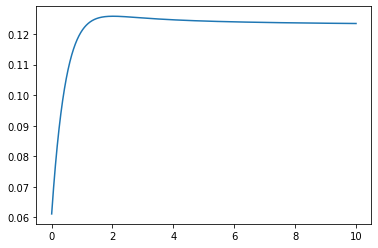

In [310]:
plt.plot(t, r)

In [319]:
ntnbs = df[df['symbol'] == 'NTN-B'].copy()

bonds = []

for _bond in ntnbs.to_dict('records'):
    REFDATE = datetime.datetime.strptime(_bond['refdate'], '%Y-%m-%d')
    _bond['maturity_date'] = datetime.datetime.strptime(_bond['maturity_date'], '%Y-%m-%d')
    _bond['issue_date'] = datetime.datetime.strptime(_bond['issue_date'], '%Y-%m-%d')
    _bond['calendar'] = MARKET_CALENDAR
    _bond['notional'] = 3702.299176
    _bond['yield'] = _bond['ref_yield']/100
    _bond['coupon_rate'] = 0.06
    _bond['coupon_frequency'] = 6
    
    bond = NTNB(**_bond)
    bonds.append(bond)

In [320]:
bonds

In [321]:
(bonds[0].theoretical_value(), bonds[0].spot_price)

(3768.2850701414186, 3777.607643)

In [322]:
bonds[0].market_cashflow

,dates,coupons,amortizations,fixings,DU,payments
43,2022-03-01,109.451123,0.000000,2022-03-02,83,109.451123
44,2022-09-01,109.451123,3702.299176,2022-09-01,211,3811.750299


In [323]:
def F(par):
    def disc(_t):
        r = nss(_t/252, par[0], par[1], par[2], par[3], par[4], par[5])
        f = (1 + r) ** (_t/252)
        return 1/f
    vals = [b.theoretical_value(discount_curve=disc) - b.spot_price for b in bonds]
    res = np.sqrt(np.sum(np.power(vals, 2.)) / len(vals))
    return res

bounds = [(-2, 2), (-2, 2), (-2, 2), (-2, 2), (0, 5), (0, 5)]
x = scipy.optimize.differential_evolution(F, bounds)

In [324]:
x.x

array([ 0.05545522, -0.27418124, -0.02924901,  0.37619728,  3.3384869 ,
        4.25349908])

In [326]:
par = x.x
t = np.arange(1, 2520) / 252
r = nss(t, par[0], par[1], par[2], par[3], par[4], par[5])

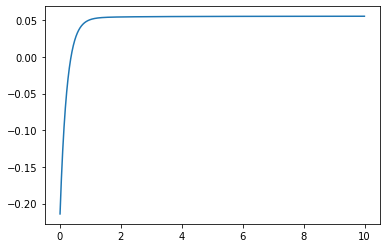

In [327]:
plt.plot(t, r)

In [330]:
x

     fun: 4.029093247475173
     jac: array([-0.32484007,  0.00709113,  0.10429213, -0.16627499,  0.04720873,
        0.08277681])
 message: 'Optimization terminated successfully.'
    nfev: 23865
     nit: 263
 success: True
       x: array([ 0.05545522, -0.27418124, -0.02924901,  0.37619728,  3.3384869 ,
        4.25349908])

In [328]:
par = x.x

def disc(_t):
    r = nss(_t/252, par[0], par[1], par[2], par[3], par[4], par[5])
    f = (1 + r) ** (_t/252)
    return 1/f


In [329]:
[b.theoretical_value(discount_curve=disc) - b.spot_price for b in bonds]

[-0.6750297016728837,
 1.6024148145570507,
 1.7303912536990538,
 4.48390793149656,
 4.681297889981579,
 -2.9546421424784057,
 -3.8989693683261066,
 -3.9043244377658084,
 -3.3684593209136438,
 -6.388603978791252,
 -1.1554661382533595,
 1.618328528856182,
 8.228522273179351]